In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. Data Generation
### $X$ is a two-dimension random variable following a mixtured (bi-variate) Normal distribution.
- ### 50%: $\mu=(3,2)$; 50%: $\mu=(3,-2)$. 
- ### $\sigma^2 = (1,1)$.
- ### When $\mu = (3,2), Y = 0$; when $\mu = (3,-2), Y = 1$.

In [2]:
########## mu vector of the distribution
left_center  = (3, 3)
right_center = (3, -2)

def get_toy_data(batch_size, left_center=left_center, right_center=right_center):
    x_data = []
    y_targets = np.zeros(batch_size)
    for batch_i in range(batch_size):
        if np.random.random() > 0.5:
            x_data.append(np.random.normal(loc=left_center))
        else:
            x_data.append(np.random.normal(loc=right_center))
            y_targets[batch_i] = 1
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.float32)

# 2. Define the Modeling Components 
## 2.1 The Model (Perceptron) and Activate Function (Sigmoid)
### - The Perceptron class has one inheritance class [nn.Module - The base class for all neural network modules.](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)
### - The [Linear (nn.Linear)](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) class in the torch.nn module is applied.
### - The activation function is the [sigmoid (torch.sigmoid)](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) function.
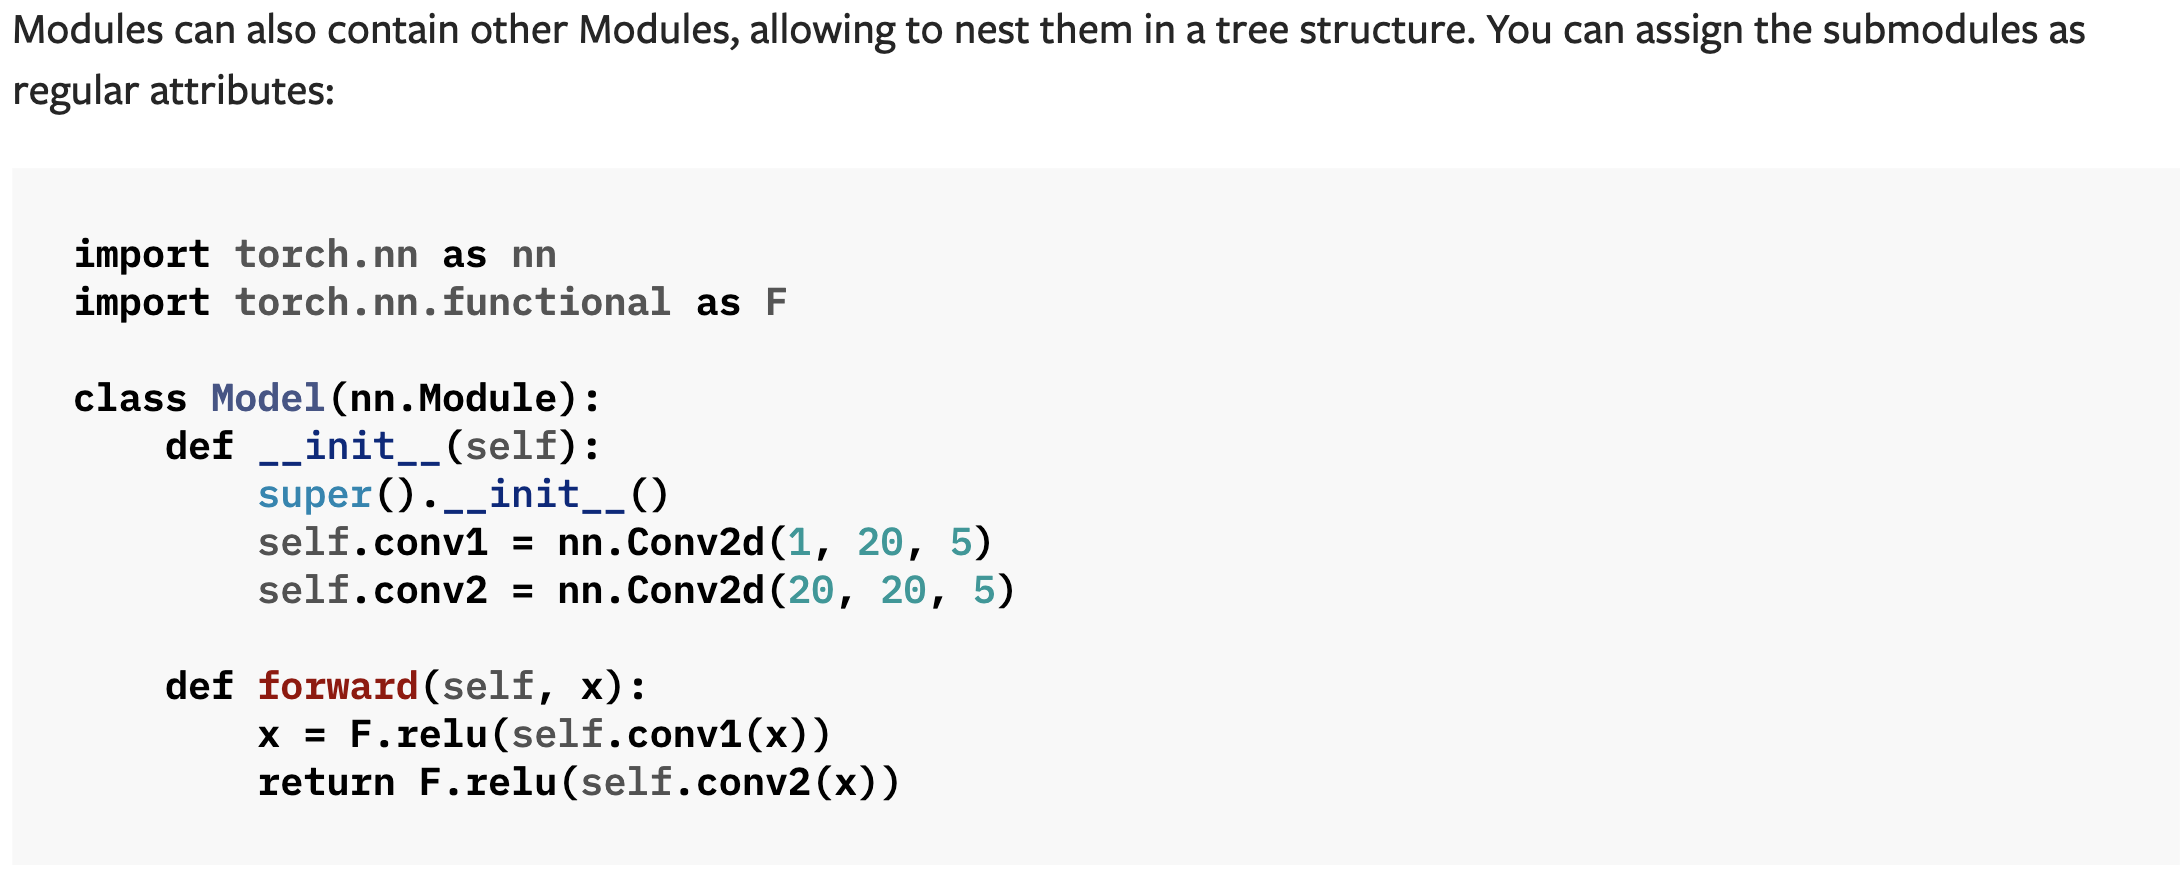


In [3]:
class Perceptron(nn.Module):
    """ A Perceptron is one Linear layer """
    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x_in):
        """The forward pass of the MLP
        Args:
            x_in (torch.Tensor): an input data tensor.
            x_in.shape should be (batch, input_dim)
        Returns:
            the resulting tensor. tensor.shape should be (batch, 1)
        """
        return torch.sigmoid(self.fc1(x_in))

### A quick example

In [4]:
x_data, y_truth = get_toy_data(batch_size=10)
input_dim       = x_data.shape[1]
perceptron      = Perceptron(input_dim=input_dim)
perceptron(x_data).view(1,10)

/tmp/ipykernel_47/2575103091.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.float32)


tensor([[0.7171, 0.0783, 0.2051, 0.2106, 0.3326, 0.1788, 0.1148, 0.8784, 0.1368,
         0.8541]], grad_fn=<ViewBackward0>)

In [5]:
###### The lines above are equivalent to running the perceptron and sigmoid separately.
print('-'*60);print('The learnable parameters "weights" and "bias" in the Linear layer.')
print(list(perceptron.parameters()))
wx_b       = ((x_data*list(perceptron.parameters())[0]).sum(1)+list(perceptron.parameters())[1]).detach().numpy()
output     = 1/(1+np.exp(-wx_b))
print('-'*60);print('Output')
output

------------------------------------------------------------
The learnable parameters "weights" and "bias" in the Linear layer.
[Parameter containing:
tensor([[-0.1679,  0.5323]], requires_grad=True), Parameter containing:
tensor([-0.1603], requires_grad=True)]
------------------------------------------------------------
Output


array([0.71714693, 0.07827859, 0.20506254, 0.21061274, 0.33264494,
       0.17882492, 0.11483929, 0.8784354 , 0.13678734, 0.85407764],
      dtype=float32)

## 2.2 The Loss Function (Binary Cross-Entropy)
### - The loss - "how far off" the model predictions are from the target.
### - The gradient of the loss function - a signal for “how much” the parameters should change (according to "how much" each parameter contributed to the loss function).

In [6]:
bce_loss = nn.BCELoss()

### A quick example

In [7]:
### output: logit 
output        = torch.randn(4, 1, requires_grad=True)
print('-'*60); print('Logit')
print(output)
sigmoid       = nn.Sigmoid()
print('-'*60); print('Probabilities')
probabilities = sigmoid(output)
print(probabilities)
targets  = torch.tensor([1, 0, 1, 0], dtype=torch.float32).view(4, 1)
print('-'*60); print('Target')
print(targets)

------------------------------------------------------------
Logit
tensor([[ 0.4416],
        [-0.1848],
        [-0.4255],
        [ 0.0803]], requires_grad=True)
------------------------------------------------------------
Probabilities
tensor([[0.6086],
        [0.4539],
        [0.3952],
        [0.5201]], grad_fn=<SigmoidBackward0>)
------------------------------------------------------------
Target
tensor([[1.],
        [0.],
        [1.],
        [0.]])


In [8]:
bce_loss = nn.BCELoss(reduction='mean')
print('-'*60); print('Using nn.BCELoss()')
print(bce_loss(probabilities, targets))

a = (torch.cat((targets, 1-targets), dim=1)*torch.cat((probabilities, 1-probabilities), dim=1)).sum(1).detach().numpy()
print('-'*60); print('Manual calculation')
print('-'*60); print(-np.mean(np.log(a)))

------------------------------------------------------------
Using nn.BCELoss()
tensor(0.6910, grad_fn=<BinaryCrossEntropyBackward0>)
------------------------------------------------------------
Manual calculation
------------------------------------------------------------
0.6910049


## 2.3 The Optimizer
### - Iteratively updating each parameter with the gradient of the loss function with respect to that parameter.
### - Implements Adam algorithm [optim.Adam()](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [9]:
### lr: learning rate (default: 1e-3)
optimizer = optim.Adam(params=perceptron.parameters(), lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

# 3. Visualizing Results
## 3.1 Without decision bountary / hyperplane

In [11]:
def visualize_results_without_hyperplane(x_data,y_data):
    """
    Args:
        x_data (torch.Tensor): an input data tensor.
        y_data (torch.Tensor): an target data tensor.
    """
    ##### Specify colors and markers
    ### colors = [the face color for y=0 points, the face color for y=1 points]
    face_colors    = ['red','yellow']
    edge_color     = 'black'
    ### markers = [the marker for y=0 points, the markerfor y=1 points]
    markers        = ['o', '*']
    
    
    x_data = x_data.numpy()
    y_data = y_data.numpy().astype(np.int32)
    
    n_classes      = 2
    all_x          = [[] for _ in range(n_classes)]
    all_facecolors = [[] for _ in range(n_classes)]
    
    ##### all_x[i] stores the x coorinates of y=i observations (i=0,1)
    ##### all_facecolors[i] stores the face color from face_colors list, for y=i observations (i=0,1)
    
    for x_i, y_i in zip(x_data, y_data):
        all_x[y_i].append(x_i)
        all_facecolors[y_i].append(face_colors[y_i])
        
    all_x = [np.stack(x_list) for x_list in all_x]
    
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    
    for x_list,facecolor_list,marker,i in zip(all_x, all_facecolors, markers,[0,1]):
        ax.scatter(x_list[:, 0],
                   x_list[:, 1], 
                   edgecolor=edge_color, 
                   marker=marker, 
                   facecolor=facecolor_list, s=100,label='y='+str(i))
    plt.title('Created Data')
    plt.legend()
    plt.show()

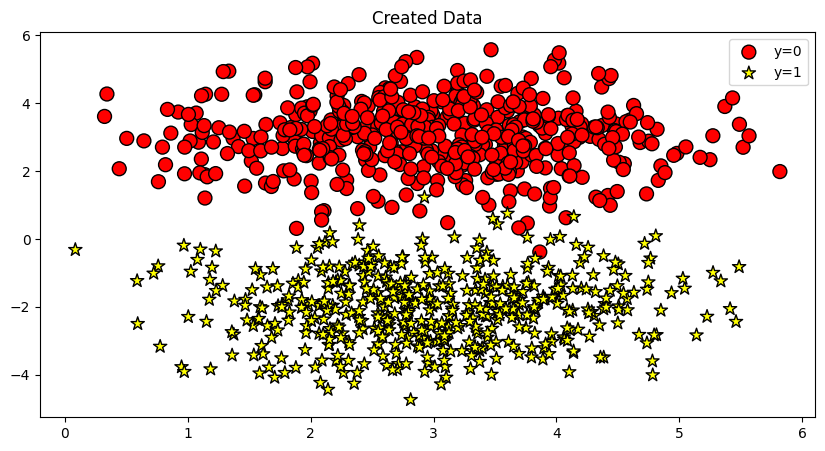

In [12]:
x_data, y_data = get_toy_data(batch_size=1000)
visualize_results_without_hyperplane(x_data, y_data)

## 3.2 With decision bountary / hyperplane

In [13]:
def visualize_results_with_hyperplane(perceptron, x_data, y_data, title=''):
    """
    Args:
        x_data (torch.Tensor): an input data tensor.
        y_data (torch.Tensor): an target data tensor.
    """    
    y_pred    = perceptron(x_data)
    y_pred    = (y_pred>0.5).to(torch.int64).squeeze().numpy().astype(np.int32)
    x_data    = x_data.numpy()
    y_data    = y_data.numpy().astype(np.int32)
    n_classes = 2

    all_x          = [[] for _ in range(n_classes)]
    all_facecolors = [[] for _ in range(n_classes)]

    ##### Specify colors and markers
    ### colors = [the face color for correctly predicted points, the face color for incorrectly predicted points]
    face_colors    = ['green','orange']
    edge_color     = 'black'
    ### markers = [the marker for y=0 points, the markerfor y=1 points]
    markers        = ['o', '*']
    
    ##### all_x[i] stores the x coorinates of y=i observations (i=0,1)
    ##### all_facecolors[i] stores the face color from face_colors list, for y=i observations (i=0,1)

    for x_i, y_pred_i, y_i in zip(x_data,y_pred,y_data):
        all_x[y_i].append(x_i)
        if y_pred_i == y_i:
            all_facecolors[y_i].append(face_colors[0])
        else: 
            all_facecolors[y_i].append(face_colors[1])

    all_x = [np.stack(x_list) for x_list in all_x]

    x_1_lim = (min([x_list[:,0].min() for x_list in all_x]), max([x_list[:,0].max() for x_list in all_x]))
    x_2_lim = (min([x_list[:,1].min() for x_list in all_x]), max([x_list[:,1].max() for x_list in all_x]))

    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    margin=0.5
    ax.set_xlim(x_1_lim[0]-margin,x_1_lim[1]+margin)
    ax.set_ylim(x_2_lim[0]-margin,x_2_lim[1]+margin)

    for x_list,facecolor_list,marker in zip(all_x, all_facecolors, markers):
        ax.scatter(x_list[:,0],
                   x_list[:,1], 
                   edgecolor = edge_color, marker=marker, 
                   facecolor = facecolor_list, s=100)

    xx1 = np.linspace(x_1_lim[0], x_1_lim[1], 30)
    xx2 = np.linspace(x_2_lim[0], x_2_lim[1], 30)
    XX2, XX1 = np.meshgrid(xx2, xx1)
    x1x2 = np.vstack([XX1.ravel(), XX2.ravel()]).T
    Z = perceptron(torch.tensor(x1x2, dtype=torch.float32)).detach().numpy().reshape(XX1.shape)
    ax.contour(XX1, XX2, Z, colors='k', levels=[0.5], linestyles=['-'])
    plt.title(title)
    plt.show()

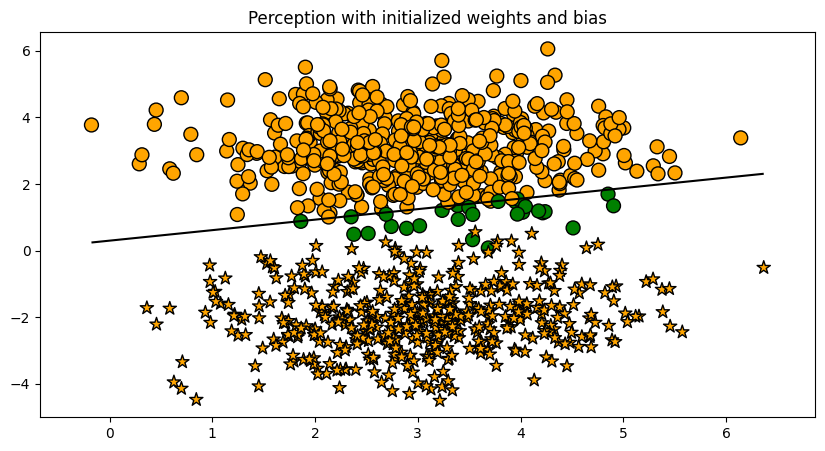

In [14]:
x_data, y_data = get_toy_data(batch_size=1000)
visualize_results_with_hyperplane(perceptron,x_data, y_data,'Perception with initialized weights and bias')

# 4. Training
### Steps in a gradient-stepping algorithm
### 1) Resets the gradients currently stored inside the model, using function [zero_grad()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html).
### 2) Computes outputs (y_pred) given the input data (x_data). 
### 3) Computes loss (y_pred) given the model outputs (y_pred) and the targets.
### 4) Iteratively propagates the loss backward through the computational graph and notifies each parameter of its gradient, using function [backward()](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html).
### 5) The optimizer instructs the parameters how to update their values knowing the gradient, using function [step()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html).
### 6) The training data is partitioned into batches. Each iteration of the gradient step (Step 1-5) is performed on a batch of data. After a number of batches, the training loop has completed an epoch. The batch size, number of batches per epoch, and number of epochs are hyperparameters. There are two nested loops in this supervised training:
#### - Inner loop: over a number of batches
#### - Outer loop: repeats the innter loop over a fixed number of epoches
### 7) Stopping (Termination) criteria: 
#### - First, train for at least 10 epochs
#### - After looping 10 epochs, stop the training if the change in loss is smaller than a threshold (say 0.01) and the loss is smaller than a threshold, say 0.4. 

### Pre-specified hyperparameters

In [15]:
lr               = 0.01  ### learning rate
batch_size       = 5000   ### size of each batch
n_batches        = 5      ### number of batches per epoch
n_epochs         = 10     ### number of epochs
change_threshold = 0.01  
loss_threshold   = 0.4    ### stopping criteria: stop if (change in loss < epsilon) AND (last_loss<loss_threshold)
input_dim        = 2      ### dimension x_data

### Generate a static data (seed is fixed), for visualization purpose. Sets the seed for generating random number
#### [torch.manual_seed()](https://pytorch.org/docs/stable/generated/torch.manual_seed.html)
#### [np.random.seed(seed)](https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html)

In [16]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
x_data_static, y_data_static = get_toy_data(batch_size)

### Modeling components (model, optimizer, loss)

In [17]:
perceptron = Perceptron(input_dim=input_dim)
optimizer  = optim.Adam(params=perceptron.parameters(), lr=lr)
bce_loss   = nn.BCELoss()

### Training
### - In the plots, for observations above the line, the model predicted labels are y=1, while below the line signifies predicted labels y=0. The green face color indicates correct model prediction, and the orange color represents incorrect predictions."

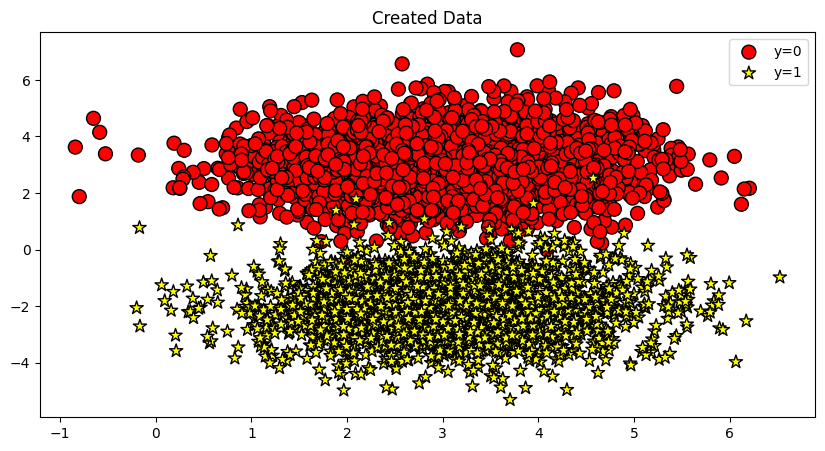

Epoch 0, Loss=0.8052, Change from last epoch=99998.1948


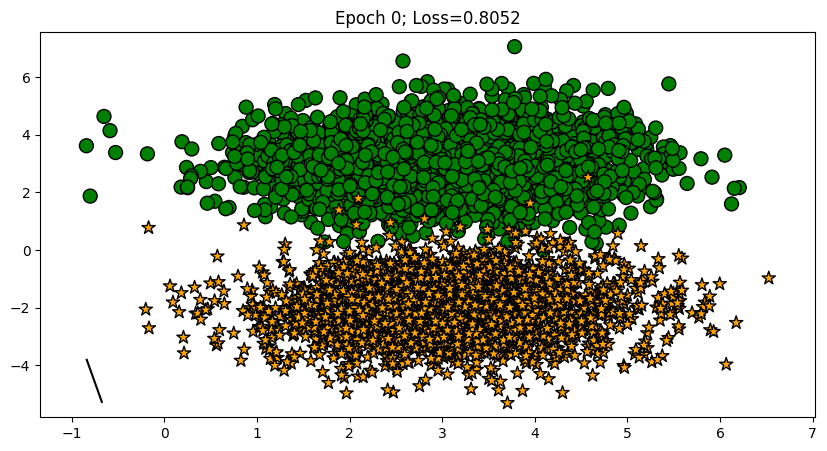

Epoch 1, Loss=0.7041, Change from last epoch=0.1012


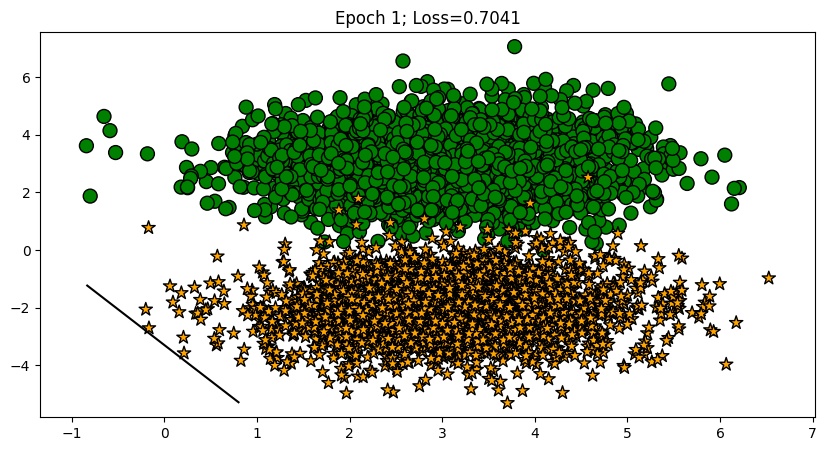

Epoch 2, Loss=0.6283, Change from last epoch=0.0758


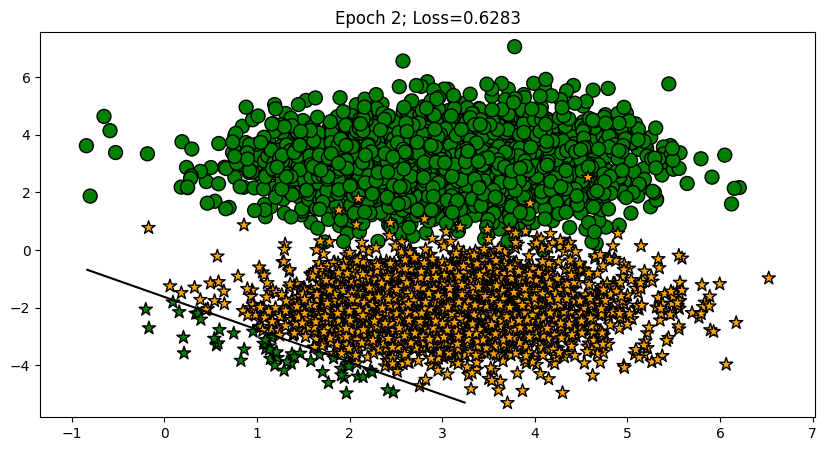

Epoch 3, Loss=0.5528, Change from last epoch=0.0755


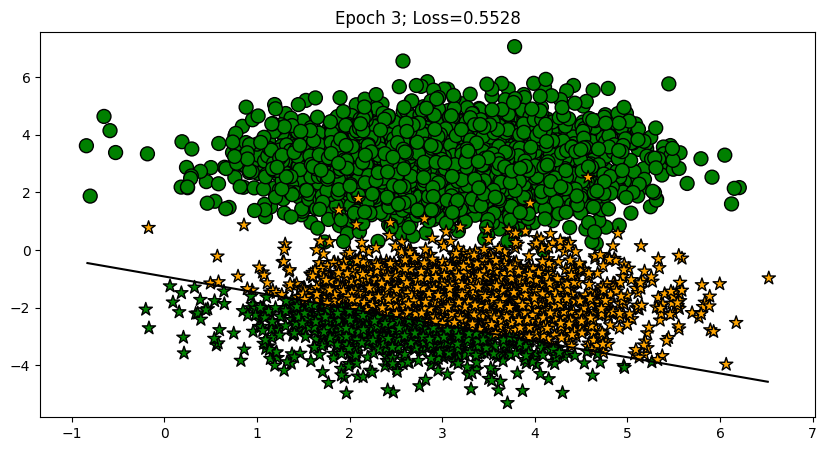

Epoch 4, Loss=0.487, Change from last epoch=0.0658


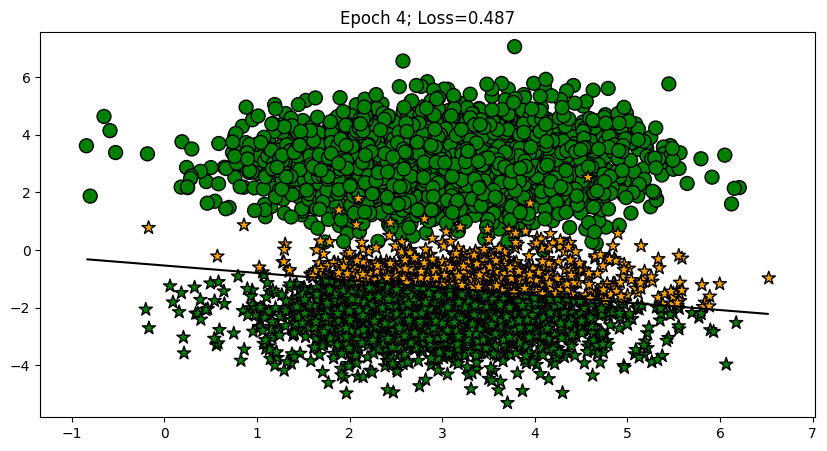

Epoch 5, Loss=0.4398, Change from last epoch=0.0472


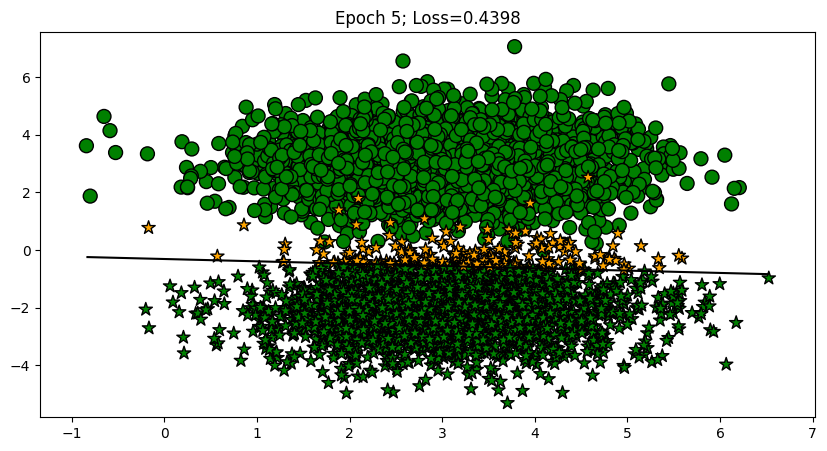

Epoch 6, Loss=0.4002, Change from last epoch=0.0396


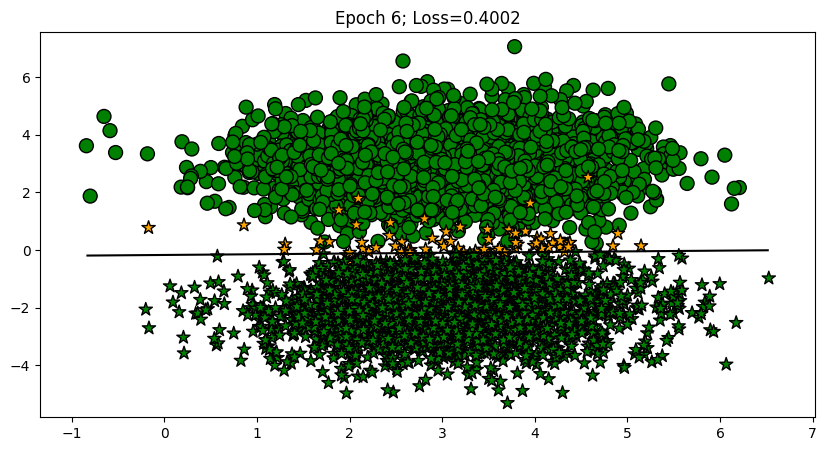

Epoch 7, Loss=0.366, Change from last epoch=0.0342


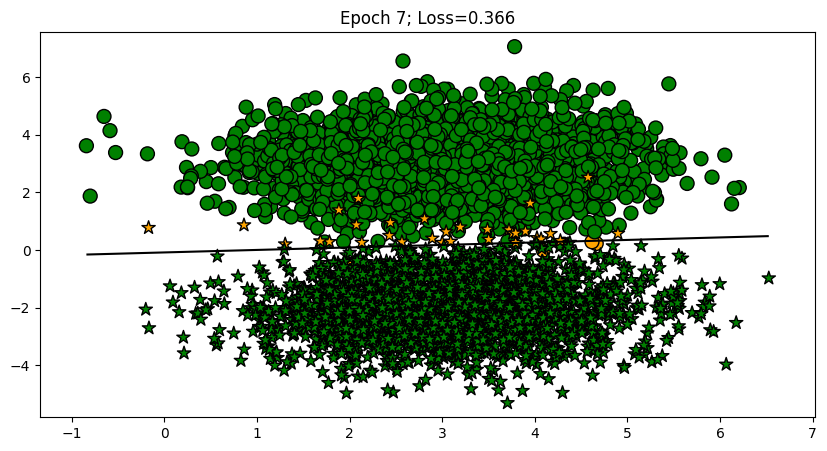

Epoch 8, Loss=0.3385, Change from last epoch=0.0275


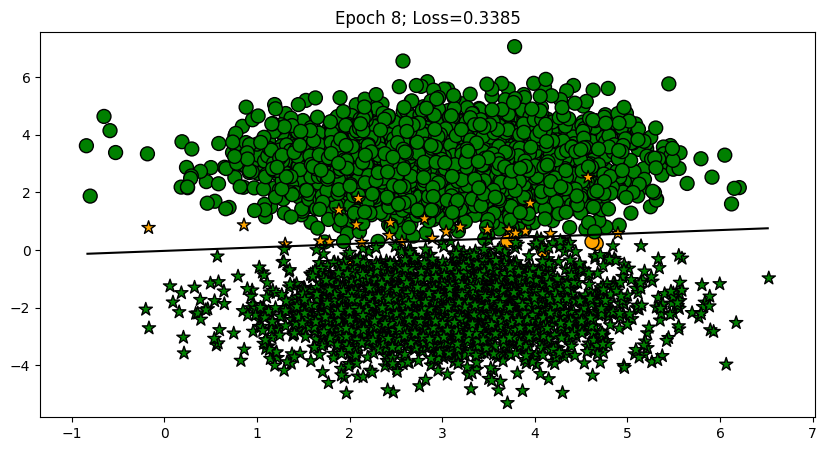

Epoch 9, Loss=0.3175, Change from last epoch=0.021


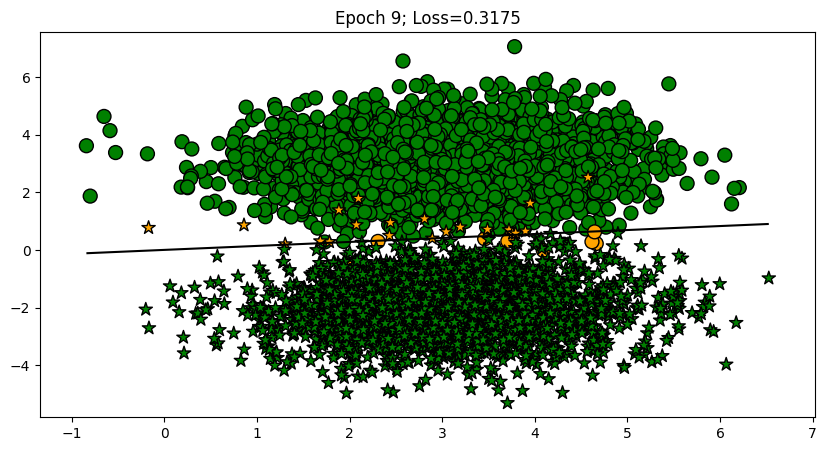

In [18]:
### Initialize epoch and last_loss
epoch           = 0 
last_loss       = 99999
last_epoch_loss = 99999
change          = 99999
losses          = []

### Plot static data
visualize_results_without_hyperplane(x_data_static, y_data_static)

### Loop
print_batch_results = False
print_epoch_results = True
create_plot         = True
while change>change_threshold or epoch<n_epochs or last_loss>loss_threshold:
    for b in range(n_batches):
        optimizer.zero_grad()
        x_data, y_target = get_toy_data(batch_size)
        y_pred = perceptron(x_data).squeeze()
        loss   = bce_loss(y_pred, y_target)
        loss.backward()
        optimizer.step()
        
        loss_value = loss.item()
        losses.append(loss_value)
        change     = abs(last_loss - loss_value)
        last_loss  = loss_value
        if print_batch_results==True:
            print(f"Epoch {epoch}, Batch {b}, Loss={round(loss_value,4)}, Change from last batch={round(change,4)}")
    if print_epoch_results==True:
        change_from_last_epoch = abs(last_epoch_loss - loss_value)
        print(f"Epoch {epoch}, Loss={round(loss_value,4)}, Change from last epoch={round(change_from_last_epoch,4)}")
    if create_plot==True:
        change_from_last_epoch = abs(last_epoch_loss - loss_value)
        title = f"Epoch {epoch}; Loss={round(loss_value,4)}"
        visualize_results_with_hyperplane(perceptron,x_data_static,y_data_static,title)
    last_epoch_loss = last_loss
    epoch += 1

# 5. References for used functions
#### 1. [zip()](https://www.programiz.com/python-programming/methods/built-in/zip): takes iterables (can be zero or more), aggregates them in a tuple, and returns it.
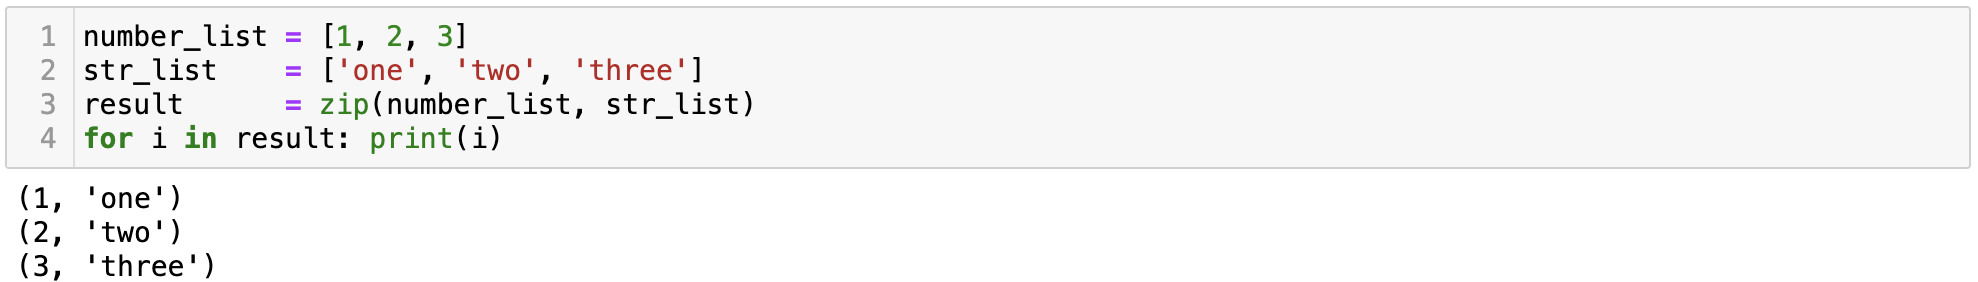
#### 2. [tensor.numpy()](https://pytorch.org/docs/stable/generated/torch.Tensor.numpy.html): Returns the tensor as a NumPy ndarray.
#### 3. [numpy.stack()](https://numpy.org/doc/stable/reference/generated/numpy.stack.html): Join a sequence of arrays along a new axis.
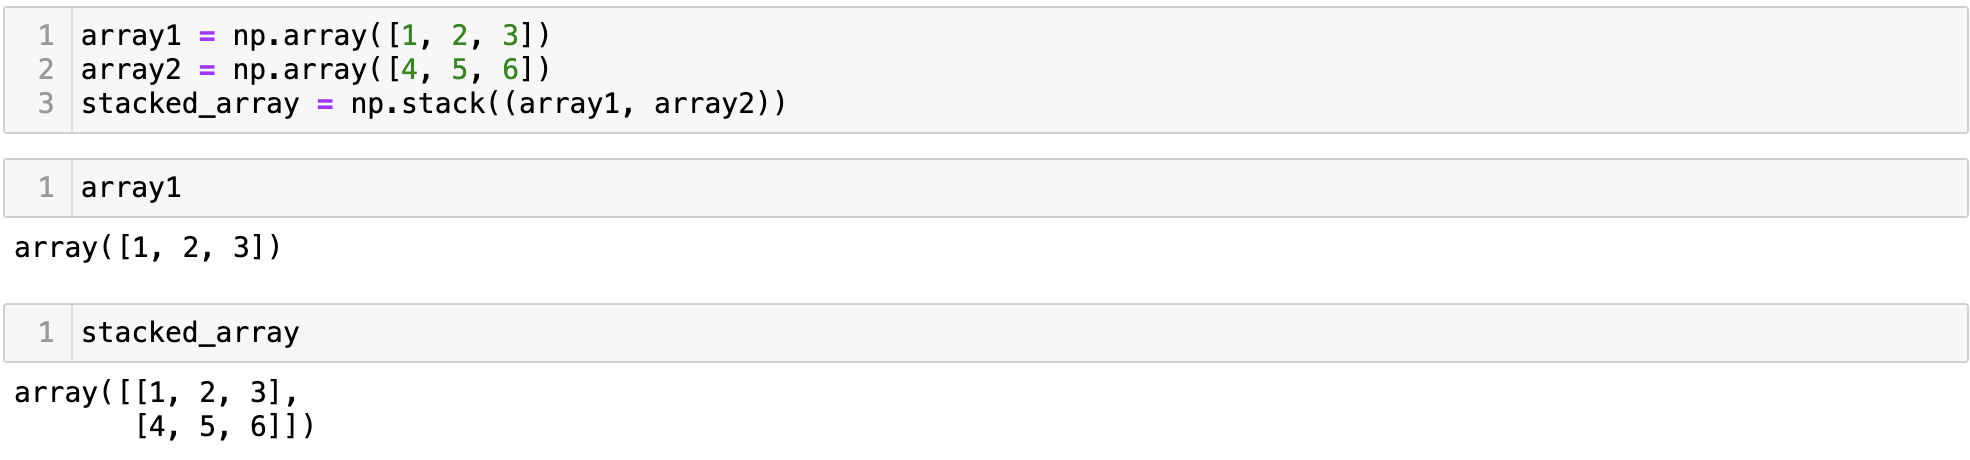
#### 4. [matplotlib.pyplot.subplots()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html): Create a figure and a set of subplots.
#### 5. [ax.scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html):A scatter plot of y vs. x with varying marker size and/or color.
#### 6. [tensor.detach()](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html): Returns a new Tensor, detached from the current graph.
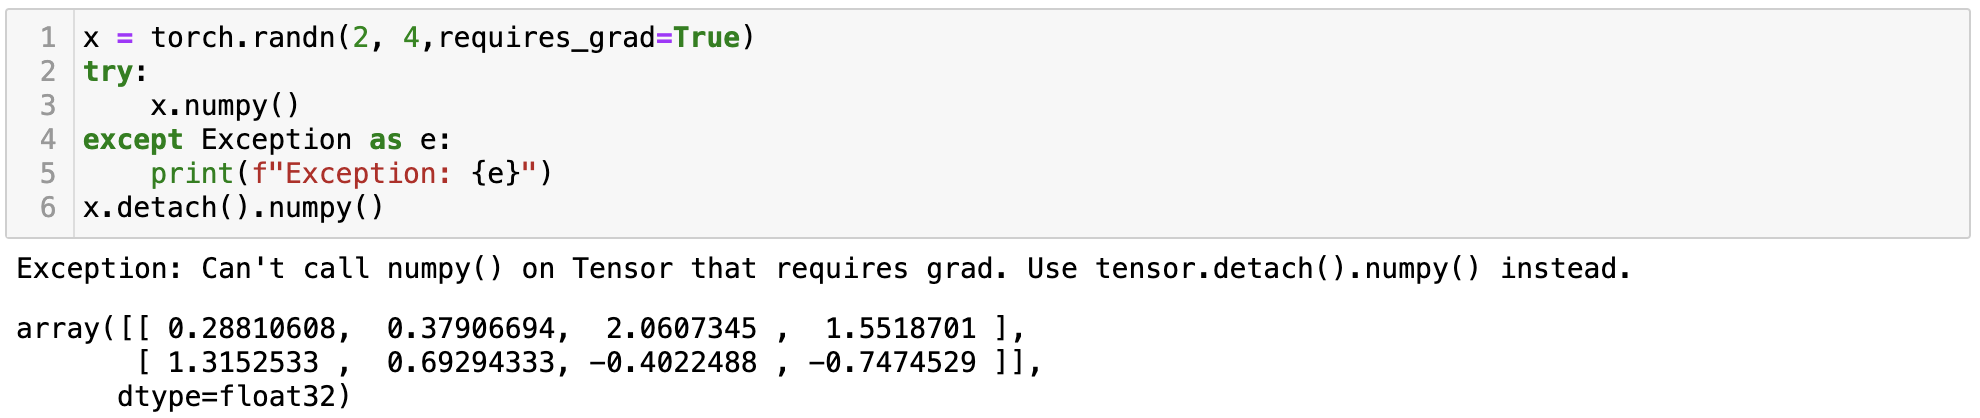
#### 7. [optimizer.zero_grad()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html): Resets the gradients of all optimized torch.Tensor s.
#### 8. [optimizer.step()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html): Performs a single optimization step (parameter update).
#### 9. [ax.contour()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.contour.html): Plot contour lines..

